#### I. Referencias consultadas

# Numerical development to resolve Time-Dependent Schrödinger equation through eigenvalue problem

## 1. Import modules with useful functions, parameters, and algorithms.

In [1]:
name_code = "03_Code";

In [37]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


## 2. Setting grid properties

* Tipo de grilla
* Discretización espacial
* Dominio
* Condiciones de contorno

In [2]:
Bohr_radius_meter=5.29177210903e−11;                        # [m]
Angstrom_to_meter=1e−10;                                    # [m/Å]
Angstrom_to_au=Angstrom_to_meter*(1.0/Bohr_radius_meter);   # [au/Å]

In [74]:
grid_type="simple_line";                            # tipo de grilla
ΔxH_1D=1.0/800.0;                                      # tamaño del elento 1D

dom_1D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au);

par_1D=(path_models,grid_type*"_01",dom_1D,ΔxH_1D);    # (path,name,dom,MeshSize)

model_1D=make_model(grid_type,par_1D);              # creamos modelo

# condiciones de contorno de tipo full dirichlet
dirichlet_tags_1D=["left_point","right_point"];
dirichlet_values_1D=[0.0,0.0];

Ω_1D,dΩ_1D,Γ_1D,dΓ_1D=measures(model_1D,3,dirichlet_tags_1D);
reffe_1D=reference_FEspaces(lagrangian,Float64,2);

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0374421s, CPU 0.015807s)
Info    : 36284 nodes 36285 elements
Info    : Writing '../outputs/03_Code/models/simple_line_01.msh'...
Info    : Done writing '../outputs/03_Code/models/simple_line_01.msh'
Info    : Reading '../outputs/03_Code/models/simple_line_01.msh'...
Info    : 3 entities
Info    : 36284 nodes
Info    : 36285 elements
Info    : Done reading '../outputs/03_Code/models/simple_line_01.msh'


In [75]:
x,pts=space_coord(dom_1D,ΔxH_1D);

## 3. Eigenvalue method

La idea acá es resolver el problema de autovalores para el hamiltoniano $\hat {h}(x)$. Los espacios Test y Trial son reales, y no complejos, entonces buscamos obtener las partes reales e imaginarias de los autoestados por separado. 

El sistema se reduce a una ecuación de Sturm-Liouville con parámetros $p( x) ,q( x) ,r( x)$ defnidos como,

\begin{align}
    \begin{cases}
    p( x) =\frac{\hbar ^{2}}{2m}\\
    q(x) = V_\binom{electron}{nucleus}(x)\\
    r( x) =1
    \end{cases} \Rightarrow -\frac{d}{dx}\left( p( x)\frac{d}{dx}\right) +q( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix} =\lambda r( x)\begin{pmatrix}
    u_{1}( x)\\
    u_{2}( x)
    \end{pmatrix}
\end{align}

### 3.1. Resolvemos problema de autovalores para $\hat {h}_{x_0=0}(x)$

Definimos los espacios Test y Trial y construimos las formas bilineales que serán de la forma:

\begin{align}
    a_{1}( u_{1} ,v_{1}) &:= \int _{\Omega }[ p( x)( \nabla v_{1} \cdotp \nabla u_{1}) +q( x)( v_{1} u_{1})] d\Omega \\
    b_{1}( u_{1} ,v_{1}) &:= \int _{\Omega } r( x)( v_{1} u_{1}) d\Omega
\end{align}

In [38]:
Vₕre_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{Float64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕre_1D=TrialFESpace(Vₕre_1D,dirichlet_values_1D);

R=0.0;R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rc=1.5*Angstrom_to_au;Rf=1.5*Angstrom_to_au; # parameters

pₕ,qₕ,rₕ=eigenvalue_problem_functions((R,R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_1D")
aₕ_1D,bₕ_1D=bilineal_forms(pₕ,qₕ,rₕ,dΩ_1D);

Set Electron-Nuclear potential with fixed R


Showing interaction potential plots

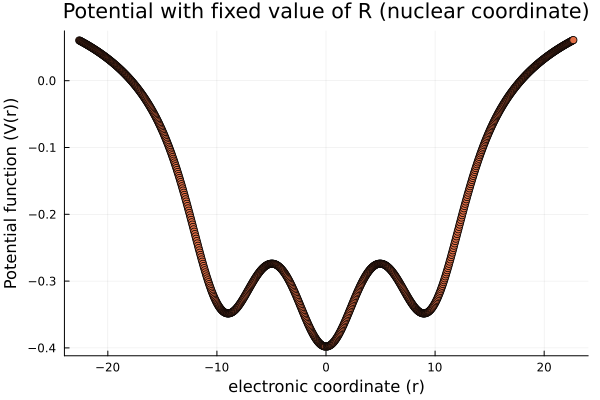

In [68]:
plt1=plot();
plt2=plot!(plt1,x,qₕ.(x),label="");
plt2=scatter!(plt1,x,qₕ.(x),label="");
plot₁=plot!(xlabel="electronic coordinate (r)",ylabel="Potential function (V(r))")
plot₁=plot!(title="Potential with fixed value of R (nuclear coordinate)")

display(plt2)

Construimos el problema de autovalores, con parámetros específicos de resolución

Notemos que fue necesario fijar el parámetro `sigma=-1.0` (valor por debajo del mínimo de potencial) para obtener autoenergías (autofunciones asociadas) ordenadas de forma creciente.

In [40]:
nevₕ=8;
probₕ_1D=EigenProblem(aₕ_1D,bₕ_1D,Uₕre_1D,Vₕre_1D;nev=nevₕ,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);

Resolvermos el problema, para obtener autovalores y autoestados

In [41]:
ϵₕ_1D,ϕₕ_1D=solve(probₕ_1D);

Y ahora guardamos la parte real e imaginaria de los autoestados en un único autoestado complejo. Para ello deberemos definir nuevos espacios Test y Trial complejos.

Como los autoestados de la parte real e imaginaria asociadas a un mismo autoestado son degenerados, tendremos que saltear de a 2 (grado de degeneración) los datos obtenidos para no duplicar resultados y quedarnos con sólo aquellos resultados no triviales.

In [56]:
Vₕreim_1D=TestFESpace(model_1D,reffe_1D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_1D);
Uₕreim_1D=TrialFESpace(Vₕreim_1D,dirichlet_values_1D);

ϕₕreim_1D=Vector{CellField}(undef,probₕ_1D.nev);

for i in 1:probₕ_1D.nev
    fₕ_1D=interpolate_everywhere(ϕₕ_1D[i],probₕ_1D.trial);
    ϕₕreim_1D[i]=interpolate_everywhere(fₕ_1D,Uₕreim_1D);
end

Showing wave function

Verificamos la normalización de los autoestados, para ello usando la función anterior y deberíamos obtener resultados cercanos a la unidad

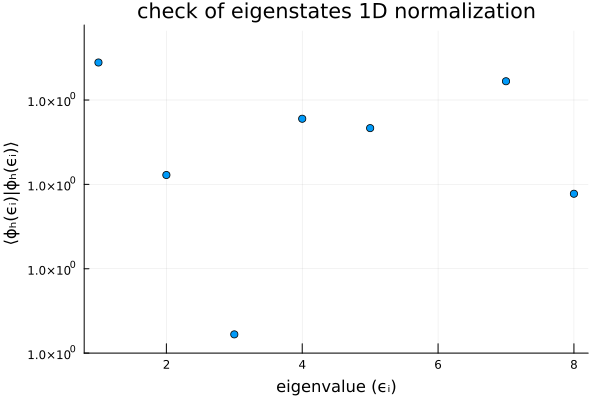

In [59]:
plotting=true
if plotting
    ϕₕreim_1D_norm=normalization_eigenstates_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D);
    plot₁=plot()
    plot₁=scatter!([i for i in 1:length(ϕₕreim_1D)],ϕₕreim_1D_norm,label="")
    plot₁=plot!(xlabel="eigenvalue (ϵᵢ)",ylabel="⟨ϕₕ(ϵᵢ)|ϕₕ(ϵᵢ)⟩")
    plot₁=plot!(title="check of eigenstates 1D normalization")
    display(plot₁)
end

Ahora podemos graficar los diferentes autoestados

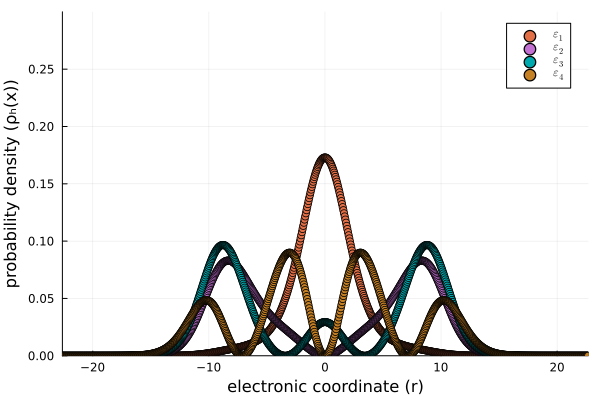

In [71]:
plotting=true
if plotting
    plot1=plot()
    ρₕreim_1D=zeros(Float64,length(pts))
    for i in [1,2,3,4]
        ρₕreim_1D=real(conj(ϕₕreim_1D[i].(pts)).*(ϕₕreim_1D[i].(pts)))
        plot1=plot!(x,ρₕreim_1D,label="",lw=2,lc=:"black",ylim=(0,0.30),xlim=(x[1],x[end]))
        plot1=scatter!(x,ρₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(0,0.30),xlim=(x[1],x[end]))
        plot1=plot!(xlabel="electronic coordinate (r)",ylabel="probability density (ρₕ(x))")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"density_eigenstates_FWP_individual.pdf");
end

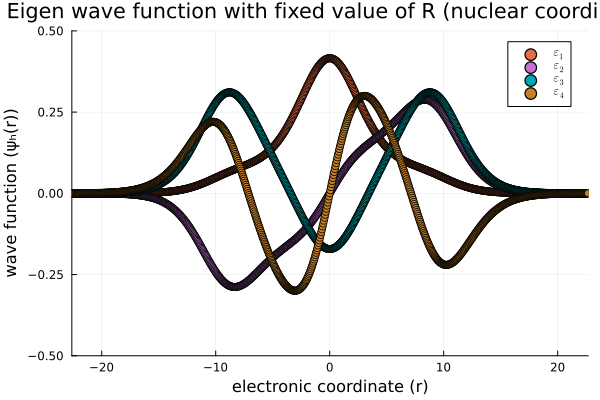

In [72]:
plotting=true
if plotting
    plot1=plot()
    for i in [1,2,3,4]
        ψₕreim_1D=real(ϕₕreim_1D[i].(pts))
        plot1=plot!(x,ψₕreim_1D,label="",lw=2,lc=:"black",ylim=(-0.5,0.5),xlim=(x[1],x[end]))
        plot1=scatter!(x,ψₕreim_1D,label="\$ \\epsilon_{$(i)}\$",lw=0.1,ylim=(-0.5,0.5),xlim=(x[1],x[end]))
        plot1=plot!(xlabel="electronic coordinate (r)",ylabel="wave function (ψₕ(r))")
        plot1=plot!(title="Eigen wave function with fixed value of R (nuclear coordinate)")
    end

    plot3=plot(plot1)
    display(plot3)
    # savefig(plot3,path_plots*"eigenstates_FWP_individual.pdf");
end

De la misma forma que para los autoestados debemos retener sólo algunos resultados de los autovalores obtenidos, recordando la degeneración de las partes real e imaginaria asociadas a un mismo autoestado.

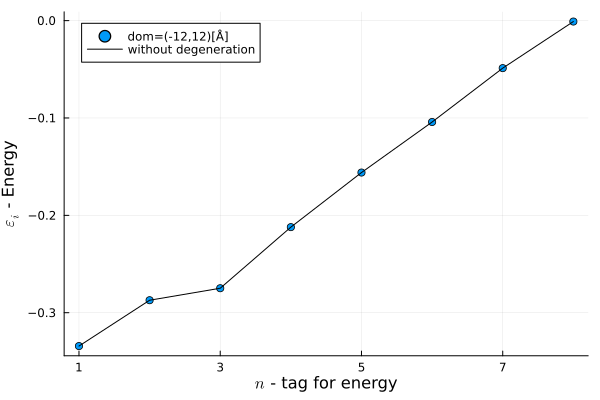

In [66]:
plotting=true

if plotting
    plot1=scatter([i for i in 1:nevₕ],ϵₕ_1D,label="dom=(-12,12)[Å]",xlabel="\$n\$ - tag for energy",ylabel="\$\\epsilon_i\$ - Energy",xticks=(1:2:nevₕ),lw=2)
    plot1=plot!([i for i in 1:nevₕ],ϵₕ_1D,label="without degeneration",lc=:"black",lw=1)
    plot1=plot!(legend=:topleft)

    plot3=plot(plot1)
    # savefig(plot3,path_plots*"eigenvalues_QHO_individual.pdf");
    display(plot3)
end

### 3.2. Calculus of differential Shannon entropy


Definition: The differential entropy $h(X)$ of a continuous variable X with density f(x) is defined as

\begin{align}
    h(X)=-\int_{S}f(x)log\left[ f(x) \right]dx
\end{align}

where $S$ is the support set of the random variable.
As in the discrete case, the differential entropy depends only on the probability density of the random variable, and therefore the differential entropy is sometimes written as $h(f)$ rather than $h(X)$.

Ref.: Cover, T.M., 1999. Elements of information theory. John Wiley & Sons.

In [67]:
S=TimeIndependet_Diff_Shannon_Entropy_1D(ϕₕreim_1D,Uₕreim_1D,dΩ_1D)

8-element Vector{Float64}:
 2.4471462875414596
 3.0126423721370363
 2.9323671813359398
 3.0523906124834808
 3.1782039820574326
 3.2659887025978005
 3.3566125274682252
 3.414052951410049

Notemos que los valores de entropía estan ordenados de forma creciente evidenciando que a medida que aumentamos la energía del sistema el desorden aumenta (paquetes de onda menos densos en alguna región espacial específica), lo cual tiene sentido teórico.

utils links:

+ https://arxiv.org/pdf/1910.01412.pdf
+ https://docs.sciml.ai/Gridap/v0.9/Fields/#Gridap.Fields.%E2%88%87

## 4. Resolve Time-Dependent Schrödinger equation (time evolution)

We can write time evolution as:

\begin{align}
    \ket{\psi ( t)} =\sum _{n=1}^{\infty } c_{n}\exp\left(\frac{-iE_{n} t}{\hbar }\right)\ket{\phi _{n}} =e^{\left(\tfrac{-i}{\hbar } t\right)}\left( c_{1} e^{E_{1}}\ket{\phi _{n}} +c_{2} e^{E_{2}}\ket{\phi _{2}} +\dotsc +c_{n} e^{E_{n}}\ket{\phi _{n}}\right)
\end{align}

Then  knowing the Hamiltonian $\hat {H}(x)$ eigenstates we can evolve the system. To do this we must first find how the initial state descomposes into the eigenstates basis of $\hat {H}(x)$.

### 4.1 Create initial state

In [93]:
function gaussian_factor(R,R₀,β)
    return exp(-β*pow((R-R₀),2));
end

function create_initial_state_1D(ϕₙ,n,TrialSpace,dΩ,R,R₀,β)
    𝛹ₓ₀=interpolate_everywhere(exp(-β*pow((R-R₀),2))*ϕₙ[n],TrialSpace);
    𝛹ₓ₀=𝛹ₓ₀*(1.0/norm_L2(𝛹ₓ₀,dΩ));
    return 𝛹ₓ₀;
end

create_initial_state_1D (generic function with 1 method)

In [94]:
𝛹ₓ₀=create_initial_state_1D(ϕₕreim_1D,1,Uₕreim_1D,dΩ_1D,R,-1.5*Angstrom_to_au,3.57*(1.0/(Angstrom_to_au*Angstrom_to_au)));

In [95]:
t_start=0.0;t_end=500#8269;                      # tiempos adimensionales inicial y final
num_steps=t_end-1;                           # number of time steps or number of points  
n_int_save=round(Int, (num_steps-1)/20);     # Intervals where data is saved n_int_save=n_inf/20=(num_steps-1)/20
Δt=abs(t_end-t_start)*(1.0/(num_steps-1));   # time step

@printf("Δx=%.6f\nΔt=%.6f\n#steps=%.d",ΔxH_1D,Δt,num_steps)

time_vec=[t_start+(i-1)*Δt for i in 1:n_int_save:num_steps];

Δx=0.001250
Δt=1.004016
#steps=499

In [96]:
𝛹ₓₜ=evolution_schrodinger_1D(𝛹ₓ₀,ϕₕreim_1D,ϵₕ₁re_1D,Uₕreim_1D,dΩ_1D,time_vec);

┌ Info: Saved animation to /tmp/jl_dynuxiHubI.gif
└ @ Plots /home/mendez/.julia/packages/Plots/bMtsB/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_dynuxiHubI.gif")
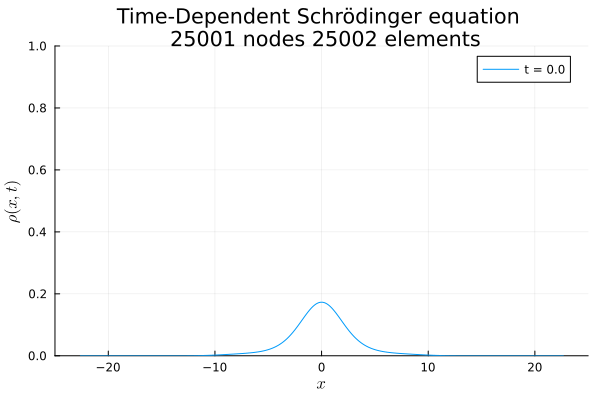

In [97]:
anim₁ = @animate for i in 1:length(time_vec)
    ρₕreim_1D=real(conj(𝛹ₓₜ[i].(pts)).*𝛹ₓₜ[i].(pts)) #./ (𝛹ₓₜ_norm[i]^2)
    plot(x[:],ρₕreim_1D,label="t = $(round(time_vec[i]; digits=4))",ylim=(0,1),xlim=(-25,25))
    plot!(title="Time-Dependent Schrödinger equation \n 25001 nodes 25002 elements",xlabel="\$x\$",ylabel="\$ \\rho (x,t)\$",ylim=(0,1),xlim=(-25,25))
end

gif(anim₁, fps = 10)

## 5. Resolve the 2D problem

In [3]:
include("../modules/module_schrodinger_equation_eigenproblem.jl"); # módulo para construir grilla (1D)

  Activating project at `~/github_repositories/my_repositories/ElectronNuclear_Coupling_Dynamics/gridap_makie`


In [4]:
function space_coord_2D(dom,Δx,Δy)
    x=[dom[1]+abs(dom[2]-dom[1])*Δx*i for i in 1:convert(Int,1.0/Δx)];
    y=[dom[3]+abs(dom[4]-dom[3])*Δy*i for i in 1:convert(Int,1.0/Δy)];
    pts=[Point(x[i],y[j]) for i in 1:convert(Int,1.0/Δx) for j in 1:convert(Int,1.0/Δy)];
    return x,y,pts;
end

space_coord_2D (generic function with 1 method)

In [16]:
grid_type="simple_rectangle_v2";    # tipo de grilla
res=2; # Resoluciones
if (res == 1)
    lc=100e-1;name=grid_type*"_coarse";
elseif (res == 2) 
    lc=10e-1;name=grid_type*"_intermediate";
elseif (res == 3)
    lc=1e-1;name=grid_type*"_finner";
end

"simple_rectangle_v2_intermediate"

In [19]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au,4.9*Angstrom_to_au);   # cantidad de FE y dominio espacial
side_r=abs(dom_2D[2]-dom_2D[1]);
side_R=abs(dom_2D[4]-dom_2D[3]);

numNodesHE=(round(Int64,side_r/lc),round(Int64,side_R/lc))  # Definimos número de nodos en los bordes
bumpFactor=0.2;
par_2D=(path_models,name,side_r,side_R,lc,numNodesHE,quad_state=false,structured_mesh=false,bumpFactor)

model_2D=make_model(grid_type,par_2D);              # creamos modelo

# condiciones de contorno de tipo full dirichlet
dirichlet_tags_2D = ["ext"];
dirichlet_values_2D = [0.0];

Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);

Choose FE-triangles (default)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.00453099s, CPU 0.004272s)
Info    : Meshing 2D...
Info    : Meshing surface 100 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.144999s, CPU 0.138342s)
Info    : 2652 nodes 5306 elements
Info    : Writing '../outputs/03_Code/models/simple_rectangle_v2_intermediate.msh'...
Info    : Done writing '../outputs/03_Code/models/simple_rectangle_v2_intermediate.msh'
Info    : Reading '../outputs/03_Code/models/simple_rectangle_v2_intermediate.msh'...
Info    : 9 entities
Info    : 2652 nodes
Info    : 5306 elements
Info    : Done reading '../outputs/03_Code/models/simple_rectangle_v2_intermediate.msh'


---------------------------------------------------
Esto es si queremos hacer discretización trivial con CartesianDiscreteModel 

In [5]:
dom_2D=(-12.0*Angstrom_to_au,12.0*Angstrom_to_au,-4.9*Angstrom_to_au,4.9*Angstrom_to_au);   # cantidad de FE y dominio espacial
n_1D_r=50;n_1D_R=50;    # cantidad de FE por dimension
ΔrH=1.0/n_1D_r; ΔRH=1.0/n_1D_R                        # tamaño del elemento 2D
partition_2D=(n_1D_r,n_1D_R);                               # grilla de tamaño n²
model_2D=CartesianDiscreteModel(dom_2D,partition_2D);   # creamos modelo con elementos cartesianos

BCtype="fulldirichlet";
if BCtype=="fulldirichlet"
    println("BCtype = ",BCtype);
    # modified
    labels_2D = get_face_labeling(model_2D);
    add_tag_from_tags!(labels_2D,"D1",[1,7,3,2,4,8]);   # lineas laterales + 4 puntos vértice
    add_tag_from_tags!(labels_2D,"D2",[5,6]);           # lineas superior e inferior
    add_tag_from_tags!(labels_2D,"D3",[9,10]);           # lineas superior e inferior
    dirichlet_values_2D=[0.0+im*0.0,0.0+im*0.0];
    dirichlet_tags_2D=["D1","D2"];
end

Ω_2D,dΩ_2D,Γ_2D,dΓ_2D=measures(model_2D,3,dirichlet_tags_2D);
reffe_2D=ReferenceFE(lagrangian,Float64,2);

DOF_r,DOF_R,pts=space_coord_2D(dom_2D,ΔrH,ΔRH);

BCtype = fulldirichlet


In [8]:
writevtk(model_2D,path_models*"CartesianDiscreteModel");

In [14]:
compute_reffaces(model_2D)

UndefVarError: UndefVarError: compute_reffaces not defined

------------------------------------------

In [15]:
VHre_2D=TestFESpace(model_2D,reffe_2D;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags=dirichlet_tags_2D);
UHre_2D=TrialFESpace(VHre_2D,dirichlet_values_2D);

R₁=-5.0*Angstrom_to_au;R₂=5.0*Angstrom_to_au;Rc=1.5*Angstrom_to_au;Rf=1.5*Angstrom_to_au; # parameters

pH_2D,qH_2D,rH_2D=eigenvalue_problem_functions((R₁,R₂,Rc,Rf);switch_potential = "Electron_Nuclear_Potential_2D")
aH_2D,bH_2D=bilineal_forms(pH_2D,qH_2D,rH_2D,dΩ_2D);

In [ ]:
nevH=4;
probH_2D=EigenProblem(aH_2D,bH_2D,UHre_2D,VHre_2D;nev=nevH,tol=10^(-9),maxiter=300,explicittransform=:none,sigma=-1.0);

In [ ]:
ϵH_2D,ϕH_2D=solve(probH_2D);

In [ ]:
# Escribimos autovectores para visualizar externamente
write_data=true;
if write_data
    for i in 1:nevH
        writevtk(Ω_2D,path_images*"eigenprob_2D_01_num$(i)",cellfields=["phi_real" => real(ϕH_2D[i]), "phi_imag" => imag(ϕH_2D[i])]);
    end
end

In [ ]:
S_2D=TimeIndependet_Diff_Shannon_Entropy_1D(ϕH_2D,UHre_2D,dΩ_2D)

In [ ]:
𝛹ₓᵢ=interpolate_everywhere(ϕH_2D[1],UHre_2D);
𝛹ₓᵢ=𝛹ₓᵢ/norm_L2(𝛹ₓᵢ,dΩ_2D);
ρₓᵢ=real(𝛹ₓᵢ'*𝛹ₓᵢ);

In [ ]:
Γ_int_line = BoundaryTriangulation(model,tags="int_line")
dΓ_int_line = Measure(Γ_int_line,2)

In [ ]:
typeof(Ω_1D)

In [ ]:
sum(∫(ρₓᵢ*(log∘ρₓᵢ))dΩ_2D)

In [ ]:
Q=CellQuadrature(Ω_2D,3)

In [ ]:
sum(∫(ρₓᵢ*(log∘ρₓᵢ))*Q)